In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from torchsummary import summary

device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
df=pd.read_csv("Dataset_with_labels.csv")
df.head()

,Class,Message,Label
0,Mangifera Indica,Elongated and oval,1
1,Mangifera Indica,"5-16 inches long and 1-3 inches wide, Elongate...",1
2,Mangifera Indica,"Pointed ends, Elongated and oval",1
3,Mangifera Indica,"Wavy margins, Glossy surface, Elongated and oval",1
4,Mangifera Indica,"Glossy surface, Elongated and oval",1


In [3]:
df['Class'].value_counts(normalize=True)

Class
Mangifera Indica    0.509804
Coffea Arabica      0.490196
Name: proportion, dtype: float64

### Train Test Split

In [4]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['Message'], df['Label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['Label'],
                                                                   shuffle=True)

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels,
                                                               shuffle=True)

In [5]:
train_labels.value_counts()

Label
1    18
0    17
Name: count, dtype: int64

In [6]:
len(train_labels)

35

### Import BERT Model and BERT Tokenizer

In [7]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [8]:
# sample data
text = ["this is mango", "this is coffee"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)
     

In [9]:
sent_id

{'input_ids': [[101, 2023, 2003, 24792, 102], [101, 2023, 2003, 4157, 102]], 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1]]}

### Tokenization

<Axes: >

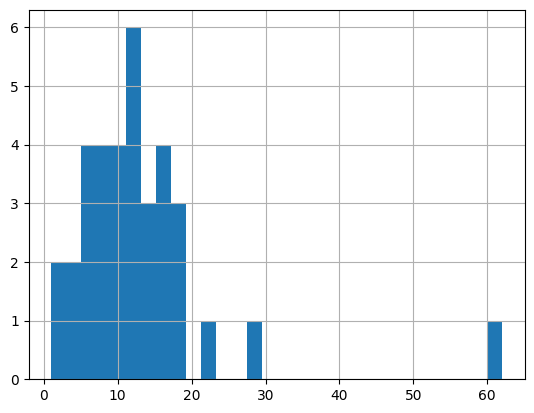

In [10]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [11]:
max_seq_len = 100
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [12]:
tokens_train.keys()

dict_keys(['input_ids', 'attention_mask'])

### Integer Sequences to Tensors

In [13]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

### Dataloaders

In [14]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
     

### Model freezing

In [15]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

### Model Arhitecture

In [16]:
# sample data
text = ["this is mango", "this is coffee"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)
t1=torch.tensor(sent_id["input_ids"]).to(device)
t2=torch.tensor(sent_id["attention_mask"]).to(device)

In [17]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      pred= self.bert(sent_id, attention_mask=mask).pooler_output
      #print(cls_hs,_)
      x = self.fc1(pred)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x
     

In [18]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)
     

In [19]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/home/moose/miniconda3/envs/torch/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
# loss function
cross_entropy  = nn.NLLLoss() 

# number of training epochs
epochs = 500

### Fine Tuning

In [31]:

# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    #print(sent_id,mask)
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)


    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

    total_accuracy+=torch.eq(torch.argmax(torch.tensor(preds),dim=1),labels.to("cpu")).sum().item()

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_data)
  avg_acc = total_accuracy / len(train_data)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, avg_acc

In [32]:
sent_id, mask, labels =next(iter(train_dataloader))
sent_id=sent_id.to(device)
mask=mask.to(device)
labels=labels.to(device)
torch.eq(torch.argmax(model(sent_id,mask),dim=1),labels).sum()

tensor(21, device='cuda:0')

In [33]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

      total_accuracy+=torch.eq(torch.argmax(torch.tensor(preds),dim=1),labels.to("cpu")).sum().item()

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_data) 

  avg_acc = total_accuracy / len(val_data)
    
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, avg_acc

In [34]:
len(train_data)

35

In [36]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, train_acc = train()
    
    #evaluate model
    valid_loss, test_acc = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    
    print(f'\nTraining Loss: {train_loss:.3f}  Training Accuracy: {train_acc:.3f}')
    print(f'Validation Loss: {valid_loss:.3f} Validation Accuract: {test_acc:.3f}')



 Epoch 1 / 500

Evaluating...

Training Loss: 0.033  Training Accuracy: 0.686
Validation Loss: 0.105 Validation Accuract: 0.500

 Epoch 2 / 500

Evaluating...

Training Loss: 0.035  Training Accuracy: 0.686
Validation Loss: 0.111 Validation Accuract: 0.500

 Epoch 3 / 500

Evaluating...

Training Loss: 0.030  Training Accuracy: 0.743
Validation Loss: 0.111 Validation Accuract: 0.500

 Epoch 4 / 500

Evaluating...

Training Loss: 0.032  Training Accuracy: 0.629
Validation Loss: 0.115 Validation Accuract: 0.500

 Epoch 5 / 500

Evaluating...

Training Loss: 0.043  Training Accuracy: 0.543
Validation Loss: 0.112 Validation Accuract: 0.500

 Epoch 6 / 500

Evaluating...

Training Loss: 0.036  Training Accuracy: 0.686
Validation Loss: 0.120 Validation Accuract: 0.500

 Epoch 7 / 500

Evaluating...

Training Loss: 0.033  Training Accuracy: 0.657
Validation Loss: 0.137 Validation Accuract: 0.375

 Epoch 8 / 500

Evaluating...

Training Loss: 0.031  Training Accuracy: 0.629
Validation Loss: 0